# Grab data

In [1]:
from herbie import Herbie, wgrib2
from pathlib import Path
import pandas as pd

import xarray as xr
from herbie.toolbox import EasyMap, ccrs, pc

In [2]:
# grab palisades data for smoke
H = Herbie(
    "2025-01-10",
    model="hrrr",
    product="sfc",
    fxx=0,
)

H.download("MASSDEN")

my_file = H.get_localFilePath("MASSDEN")

my_file, my_file.exists()

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


(PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2'),
 True)

# Use `wgrib` wrapper to subregion the data

In [3]:
# Print the standard inventory of a grib2 file
print(wgrib2.inventory(my_file))

1:0:d=2025011000:MASSDEN:8 m above ground:anl:



In [4]:
# Create a standard inventory file

idx_file = wgrib2.create_inventory_file(my_file)

idx_file, idx_file.exists()

(PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.idx'),
 True)

In [5]:
wgrib2.vector_relative(my_file)

All winds are grid-relative winds.


{'winds(grid)'}

In [6]:
# Create a regional subset of the file
lat_bottom, lat_top = 33.28, 34.86
lon_bottom, lon_top = -119.1, -117.3

extent = (lon_bottom, lon_top, lat_bottom, lat_top)

subset_file = wgrib2.region(my_file, extent, name="la_region")
subset_file

PosixPath('/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2')

In [7]:
# Look at the inventory file again to see it is different 
# from before the region subset
pd.read_csv(str(subset_file) + ".idx", delimiter=":", header=None)

,0,1,2,3,4,5,6
0,1,0,d=2025011000,MASSDEN,8 m above ground,anl,NaN


In [8]:
my_file, subset_file

(PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2'),
 PosixPath('/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2'))

# Convert to `xarray` and visualize subregion

In [9]:
# Get crs from a regular Herbie object
ds = H.xarray("MASSDEN")
crs = ds.herbie.crs

# (can't use Herbie to open FILE yet, so just use xarray)
ds_region = xr.open_dataset(subset_file, engine="cfgrib")

/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/herbie/core.py:1106: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTime

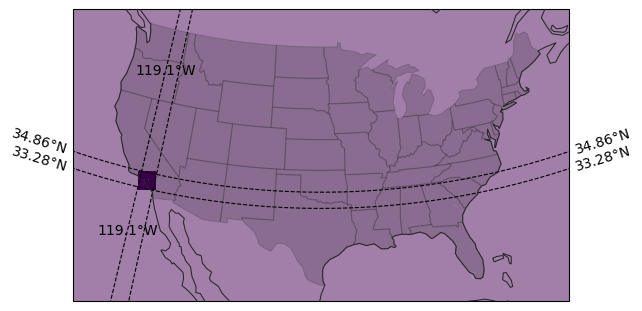

In [20]:
ax = EasyMap(crs=crs).STATES(color="k").ax
ax.pcolormesh(ds.longitude, ds.latitude, ds.mdens, alpha=0.5, transform=pc)
ax.pcolormesh(ds_region.longitude, ds_region.latitude, ds_region.mdens * 1000000000, transform=pc)

ax.gridlines(xlocs=extent[:2], ylocs=extent[2:], color="k", ls="--", draw_labels=True)

In [11]:
ds

<xarray.Dataset> Size: 38MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2025-01-10
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 8.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B ...
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    mdens                (y, x) float32 8MB 1.52e-09 1.52e-09 ... 8.855e-26
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/mgraca/data/hrrr/20250110/subset_d9ef9dd4_...
    search:                  MASSDEN

In [12]:
ds_region

<xarray.Dataset> Size: 92kB
Dimensions:            (y: 69, x: 67)
Coordinates:
    time               datetime64[ns] 8B ...
    step               timedelta64[ns] 8B ...
    heightAboveGround  float64 8B ...
    latitude           (y, x) float64 37kB 32.97 32.98 32.99 ... 35.15 35.15
    longitude          (y, x) float64 37kB 241.0 241.0 241.1 ... 242.6 242.6
    valid_time         datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    mdens              (y, x) float32 18kB 1.6e-10 1.6e-10 ... 8.855e-26
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-03-20T19:05 GRIB to CDM+CF via cfgrib-0.9.1...

In [13]:
ds_region['mdens']

<xarray.DataArray 'mdens' (y: 69, x: 67)> Size: 18kB
array([[1.60000e-10, 1.60000e-10, 1.60000e-10, ..., 2.40000e-10, 8.85486e-26,
        8.85486e-26],
       [1.60000e-10, 1.60000e-10, 1.60000e-10, ..., 8.00000e-11, 8.85486e-26,
        8.85486e-26],
       [1.60000e-10, 1.60000e-10, 1.60000e-10, ..., 8.85486e-26, 8.85486e-26,
        8.85486e-26],
       ...,
       [8.00000e-11, 8.00000e-11, 1.60000e-10, ..., 8.85486e-26, 8.85486e-26,
        8.85486e-26],
       [1.60000e-10, 1.60000e-10, 2.40000e-10, ..., 8.85486e-26, 8.85486e-26,
        8.85486e-26],
       [4.00000e-10, 3.20000e-10, 3.20000e-10, ..., 8.85486e-26, 8.85486e-26,
        8.85486e-26]], shape=(69, 67), dtype=float32)
Coordinates:
    time               datetime64[ns] 8B ...
    step               timedelta64[ns] 8B ...
    heightAboveGround  float64 8B ...
    latitude           (y, x) float64 37kB 32.97 32.98 32.99 ... 35.15 35.15
    longitude          (y, x) float64 37kB 241.0 241.0 241.1 ... 242.6 242.6
    valid_time         datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Attributes: (12/34)
    GRIB_paramId:                             400000
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      4623
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Mass density
    GRIB_shortName:                           mdens
    GRIB_units:                               kg m**-3
    long_name:                                Mass density
    units:                                    kg m**-3
    standard_name:                            unknown

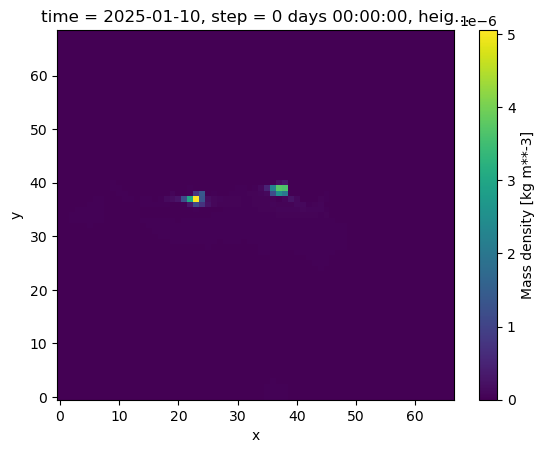

In [14]:
ds_region['mdens'].plot()

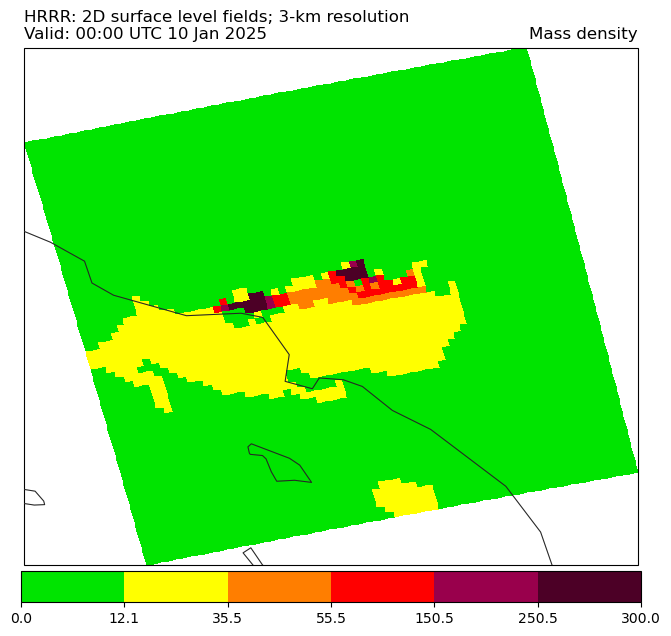

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
from herbie.toolbox import EasyMap, pc, ccrs
from herbie import paint

def plot(ds, coords=None, save=False, proj=pc):
    micro_per_k = 1000000000

    plt.figure()
    ax = EasyMap("50m", crs=proj, figsize=[10, 8]).BORDERS().STATES().ax
    
    if coords != None:
        ax.set_extent(coords)
    
    p = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.mdens * micro_per_k,
        transform=pc,
        **paint.AQIPm25.kwargs2,
    )
    plt.colorbar(
        p,
        ax=ax,
        orientation="horizontal",
        pad=0.01,
        shrink=0.8,
        **paint.AQIPm25.kwargs2,
    )
    
    ax.set_title(
        f"HRRR: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
        loc="left",
    )
    ax.set_title(ds.mdens.GRIB_name, loc="right")

    if save:
        plt.savefig(f"images/hrrr_viz_{str(int(ds.step.item() / 3600000000000)).zfill(2)}.png")
        
    plt.show()
    plt.clf()

plot(ds_region)

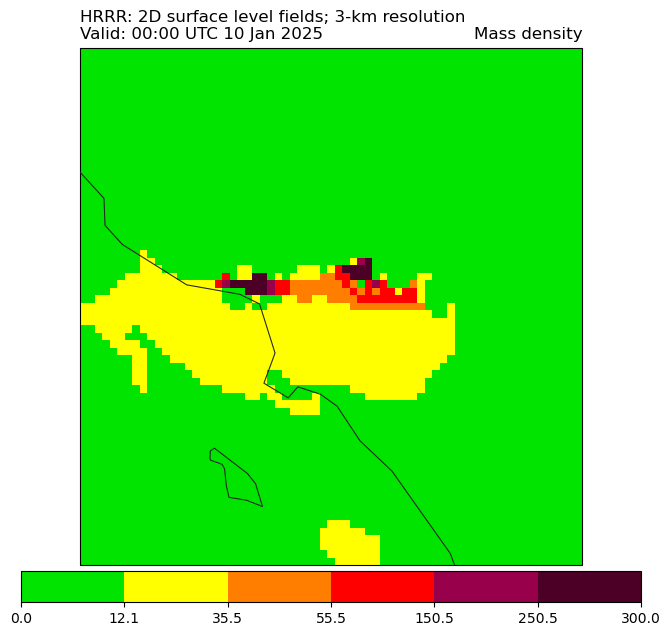

<Figure size 640x480 with 0 Axes>

In [16]:
plot(ds_region, proj=ds.herbie.crs)

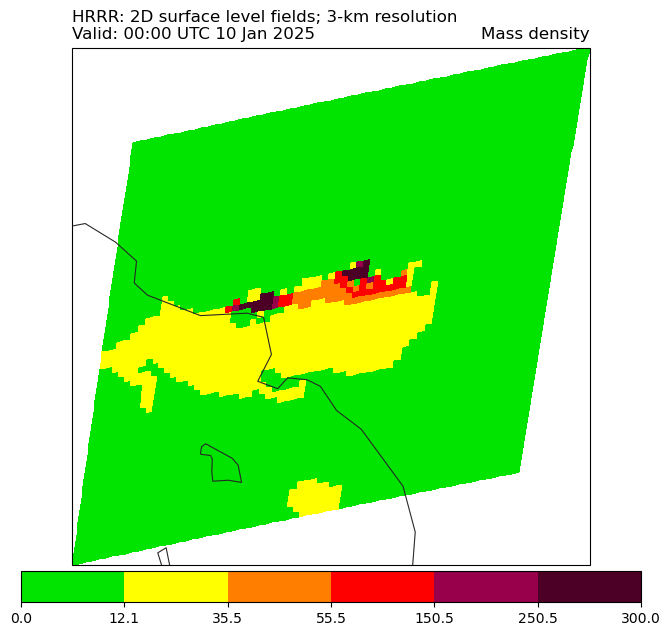

<Figure size 640x480 with 0 Axes>

In [17]:
plot(ds_region, proj=ccrs.Robinson())

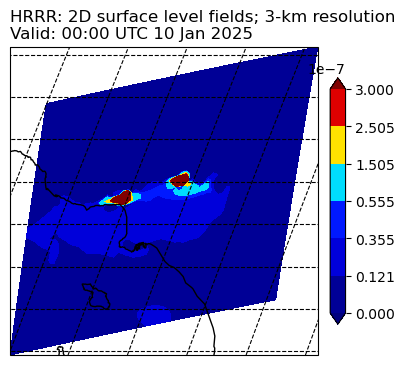

In [19]:
import numpy as np

# attempting to look the same as the pwwb notebook
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m",linewidth=1)
ax.gridlines(linestyle='--',color='black')

# Set contour levels, then draw the plot and a colorbar
clevs = [a / 1000000000 for a in [0, 12.1, 35.5, 55.5, 150.5, 250.5, 300]]
clevs = np.array(np.array(clevs))
plt.contourf(ds_region.longitude, ds_region.latitude, ds_region.mdens, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet,extend="both")
#plt.title(sub_ds.mdens.GRIB_name, size=14)
ax.set_title(
    f"HRRR: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
#ax.set_title(ds.mdens.GRIB_name, loc="right")
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.ax.tick_params(labelsize=10)

In [ ]:
ds_region['mdens'].to_numpy()

The result here is the NaN values are gone, but this is implicitly in LCC projection, not Plate Carree. I'm not sure how we can get rid of the NaN values while projecting onto Plate Carree.